# Importing Required packages

In [1]:
!pip install patchify --quiet
!pip install opendatasets --quiet
!pip install segmentation_models --quiet
!pip install wandb --quiet
!pip install keract

In [2]:
import wandb

wandb.login(key='0df3ee3be92488b9af0d7d8c06b9bd84062babf9')

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [3]:
import os
import random
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import opendatasets as od
from PIL import Image
from patchify import patchify
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.layers import concatenate, BatchNormalization, Dropout, Lambda

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
# od.download('https://www.kaggle.com/datasets/humansintheloop/semantic-segmentation-of-aerial-imagery')

In [5]:
from keras import backend as K

## Copying path to collect images and initializing constants, variables

In [6]:
project_path = '/kaggle/input/semantic-segmentation-of-aerial-imagery'
dataset_name = 'Semantic segmentation dataset'
patch_size = 256
min_max_scaler = MinMaxScaler()
image_dataset = []
mask_dataset = []

#### Saving images into image_dataset and mask_dataset

In [7]:
for image_type in ['images', 'masks']:
    if image_type == 'images':
        image_extension = 'jpg'
    elif image_type == 'masks':
        image_extension = 'png'

    for tile_id in range(1,9):
        for image_id in range(1,10):
            image_path = f'{project_path}/{dataset_name}/Tile {tile_id}/{image_type}/image_part_00{image_id}.{image_extension}'
            image = cv2.imread(image_path)

            if image is not None:
                if image_type == 'masks':
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                size_x = (image.shape[0] // patch_size) * patch_size
                size_y = (image.shape[1] // patch_size) * patch_size

                image = Image.fromarray(image)
                image = image.crop((0 , 0 , size_x, size_y))

                image = np.array(image)

                patched_images = patchify(image, (patch_size, patch_size, 3), step = patch_size)

                for i in range(patched_images.shape[0]):
                    for j in range(patched_images.shape[1]):
                        individual_patched_image = patched_images[i,j,:,:]

                        if image_type == 'images':
                            image = individual_patched_image
                            pixels = image.reshape(-1, image.shape[-1])
                            pixels = min_max_scaler.fit_transform(pixels)
                            image = pixels.reshape(image.shape)

                            individual_patched_image = image[0]
                            image_dataset.append(individual_patched_image)
                        elif image_type == 'masks':
                            individual_patched_mask = individual_patched_image[0]
                            mask_dataset.append(individual_patched_mask)


In [8]:
print(len(image_dataset), len(mask_dataset))

1305 1305


## Data Preprocessing

In [9]:
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)
print(image_dataset.shape, mask_dataset.shape)

(1305, 256, 256, 3) (1305, 256, 256, 3)


875


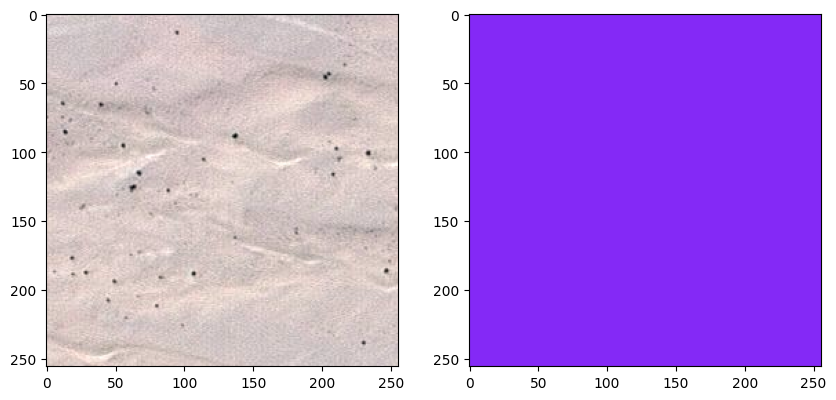

In [10]:
random_int = random.randint(0, len(image_dataset))
print(random_int)
plt.figure(figsize=(10,20))
plt.subplot(121)
plt.imshow(image_dataset[random_int])
plt.subplot(122)
plt.imshow(mask_dataset[random_int])

In [11]:
class_building = '#3C1098'
class_building = class_building.lstrip('#')
class_building = np.array(tuple(int(class_building[i:i+2], 16) for i in (0,2,4)))
print(class_building)

class_land = '#8429F6'
class_land = class_land.lstrip('#')
class_land = np.array(tuple(int(class_land[i:i+2], 16) for i in (0,2,4)))
print(class_land)

class_road = '#6EC1E4'
class_road = class_road.lstrip('#')
class_road = np.array(tuple(int(class_road[i:i+2], 16) for i in (0,2,4)))
print(class_road)

class_vegetation = '#FEDD3A'
class_vegetation = class_vegetation.lstrip('#')
class_vegetation = np.array(tuple(int(class_vegetation[i:i+2], 16) for i in (0,2,4)))
print(class_vegetation)

class_water = '#50E3C2'
class_water = class_water.lstrip('#')
class_water = np.array(tuple(int(class_water[i:i+2], 16) for i in (0,2,4)))
print(class_water)

class_unlabeled = '#9B9B9B'
class_unlabeled = class_unlabeled.lstrip('#')
class_unlabeled = np.array(tuple(int(class_unlabeled[i:i+2], 16) for i in (0,2,4)))
print(class_unlabeled)

[ 60  16 152]
[132  41 246]
[110 193 228]
[254 221  58]
[ 80 227 194]
[155 155 155]


In [12]:
def rgb_to_label(label):
    label_segment = np.zeros(label.shape, dtype=np.uint8)
    label_segment[np.all(label == class_water, axis=-1)] = 0
    label_segment[np.all(label == class_land, axis = -1)] = 1
    label_segment[np.all(label == class_road, axis = -1)] = 2
    label_segment[np.all(label == class_building, axis = -1)] = 3
    label_segment[np.all(label == class_vegetation, axis = -1)] = 4
    label_segment[np.all(label == class_unlabeled, axis = -1)] = 5
    label_segment = label_segment[:, :, 0]
    return label_segment

In [13]:
labels = []

In [14]:
for i in range(mask_dataset.shape[0]):
    label = rgb_to_label(mask_dataset[i])
    labels.append(label)

In [15]:
labels = np.expand_dims(np.array(labels),axis=3)

In [16]:
labels.shape

(1305, 256, 256, 1)

In [17]:
print(f'Total Unique values based on mask: {np.unique(labels)}')

Total Unique values based on mask: [0 1 2 3 4 5]


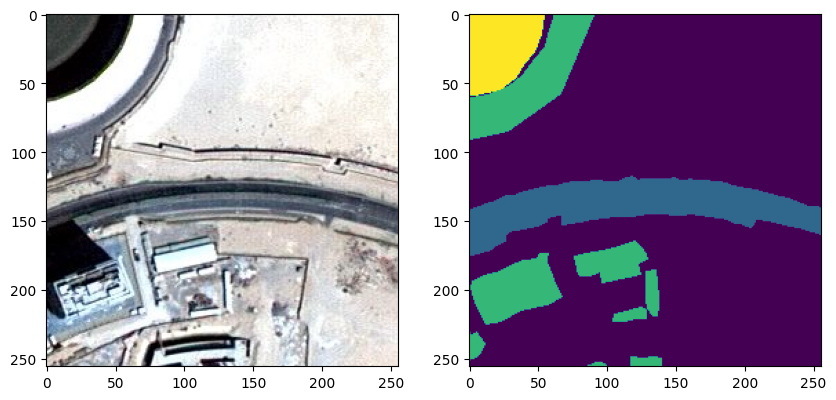

In [18]:
random_int = random.randint(0, len(image_dataset))
plt.figure(figsize=(10,20))
plt.subplot(121)
plt.imshow(image_dataset[random_int])
plt.subplot(122)
plt.imshow(labels[random_int])

In [19]:
label_categorical_dataset = to_categorical(labels, len(np.unique(labels)))
master_dataset = image_dataset

In [20]:
x_train, x_test, y_train, y_test = train_test_split(master_dataset, label_categorical_dataset, test_size=0.2, random_state=42)

In [21]:
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(1044, 256, 256, 3) (261, 256, 256, 3) (1044, 256, 256, 6) (261, 256, 256, 6)


In [22]:
image_height = x_train.shape[1]
image_width = x_train.shape[2]
image_channels = x_train.shape[3]
total_classes = y_train.shape[3]

## Model Building - Unet

In [23]:
def jaccard_coef(y_true, y_pred):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)
    intersection = K.sum(y_true_flatten * y_pred_flatten)
    final_coef_value = (intersection + 1.0) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) - intersection + 1.0)
    return final_coef_value

#### Model

In [24]:
def multi_unet_model(n_classes = 5, image_height = 256, image_width = 256, image_channels = 1):
    inputs = Input((image_height, image_width, image_channels))

    source_input = inputs
    c1 = Conv2D(16, kernel_size=(3,3), activation='relu', kernel_initializer="he_normal", padding="same")(source_input)
    c1 = Dropout(0.2)(c1)
    c1 = Conv2D(16, kernel_size=(3,3), activation='relu', kernel_initializer="he_normal", padding="same")(c1)
    p1 = MaxPooling2D((2,2))(c1)

    c2 = Conv2D(32, kernel_size=(3,3), activation='relu', kernel_initializer="he_normal", padding="same")(p1)
    c2 = Dropout(0.2)(c2)
    c2 = Conv2D(32, kernel_size=(3,3), activation='relu', kernel_initializer="he_normal", padding="same")(c2)
    p2 = MaxPooling2D((2,2))(c2)

    c3 = Conv2D(64, kernel_size=(3,3), activation='relu', kernel_initializer="he_normal", padding="same")(p2)
    c3= Dropout(0.2)(c3)
    c3 = Conv2D(64, kernel_size=(3,3), activation='relu', kernel_initializer="he_normal", padding="same")(c3)
    p3 = MaxPooling2D((2,2))(c3)

    c4 = Conv2D(128, kernel_size=(3,3), activation='relu', kernel_initializer="he_normal", padding="same")(p3)
    c4= Dropout(0.2)(c4)
    c4 = Conv2D(128, kernel_size=(3,3), activation='relu', kernel_initializer="he_normal", padding="same")(c4)
    p4 = MaxPooling2D((2,2))(c4)

    c5 = Conv2D(256, kernel_size=(3,3), activation='relu', kernel_initializer="he_normal", padding="same")(p4)
    c5 = Dropout(0.2)(c5)
    c5 = Conv2D(256, kernel_size=(3,3), activation='relu', kernel_initializer="he_normal", padding="same")(c5)

    u6 = Conv2DTranspose(128, (2,2), strides= (2,2), padding="same")(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, kernel_size=(3,3), activation='relu', kernel_initializer="he_normal", padding="same")(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, kernel_size=(3,3), activation='relu', kernel_initializer="he_normal", padding="same")(c6)

    u7 = Conv2DTranspose(64, (2,2), strides= (2,2), padding="same")(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, kernel_size=(3,3), activation='relu', kernel_initializer="he_normal", padding="same")(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, kernel_size=(3,3), activation='relu', kernel_initializer="he_normal", padding="same")(c7)

    u8 = Conv2DTranspose(32, (2,2), strides= (2,2), padding="same")(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, kernel_size=(3,3), activation='relu', kernel_initializer="he_normal", padding="same")(u8)
    c8 = Dropout(0.2)(c8)
    c8 = Conv2D(32, kernel_size=(3,3), activation='relu', kernel_initializer="he_normal", padding="same")(c8)

    u9 = Conv2DTranspose(16, (2,2), strides= (2,2), padding="same")(c8)
    u9 = concatenate([u9, c1], axis = 3)
    c9 = Conv2D(16, kernel_size=(3,3), activation='relu', kernel_initializer="he_normal", padding="same")(u9)
    c9 = Dropout(0.2)(c9)
    c9 = Conv2D(16, kernel_size=(3,3), activation='relu', kernel_initializer="he_normal", padding="same")(c9)


    outputs = Conv2D(n_classes, kernel_size=(1,1), activation='softmax')(c9)
    model = Model(inputs = [inputs], outputs = [outputs])
    return model


In [25]:
metrics = ["accuracy", jaccard_coef]

In [26]:
def get_deep_learning_model():
    return multi_unet_model(n_classes= total_classes,
                            image_height= image_height,
                            image_width= image_width,
                            image_channels = image_channels)

In [27]:
model = get_deep_learning_model()

In [28]:
model.get_config()

{'name': 'model',
 'trainable': True,
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 256, 256, 3),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'input_1'},
   'name': 'input_1',
   'inbound_nodes': []},
  {'class_name': 'Conv2D',
   'config': {'name': 'conv2d',
    'trainable': True,
    'dtype': 'float32',
    'filters': 16,
    'kernel_size': (3, 3),
    'strides': (1, 1),
    'padding': 'same',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'groups': 1,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'HeNormal', 'config': {'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None},
   'name': 'conv2d',
   'inbound_nodes': [[['input_1', 0, 0, {}]]]},
  {'class_name': 'Dropout',
   

## Generating loss function

In [29]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [30]:
weights = [0.166, 0.166, 0.166, 0.166, 0.166, 0.166]

dice_loss = sm.losses.DiceLoss(class_weights=weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

### Model Compilation

In [31]:
model.compile(optimizer='adam', loss=total_loss, metrics = metrics)

In [32]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [33]:
from keras.utils.vis_utils import plot_model

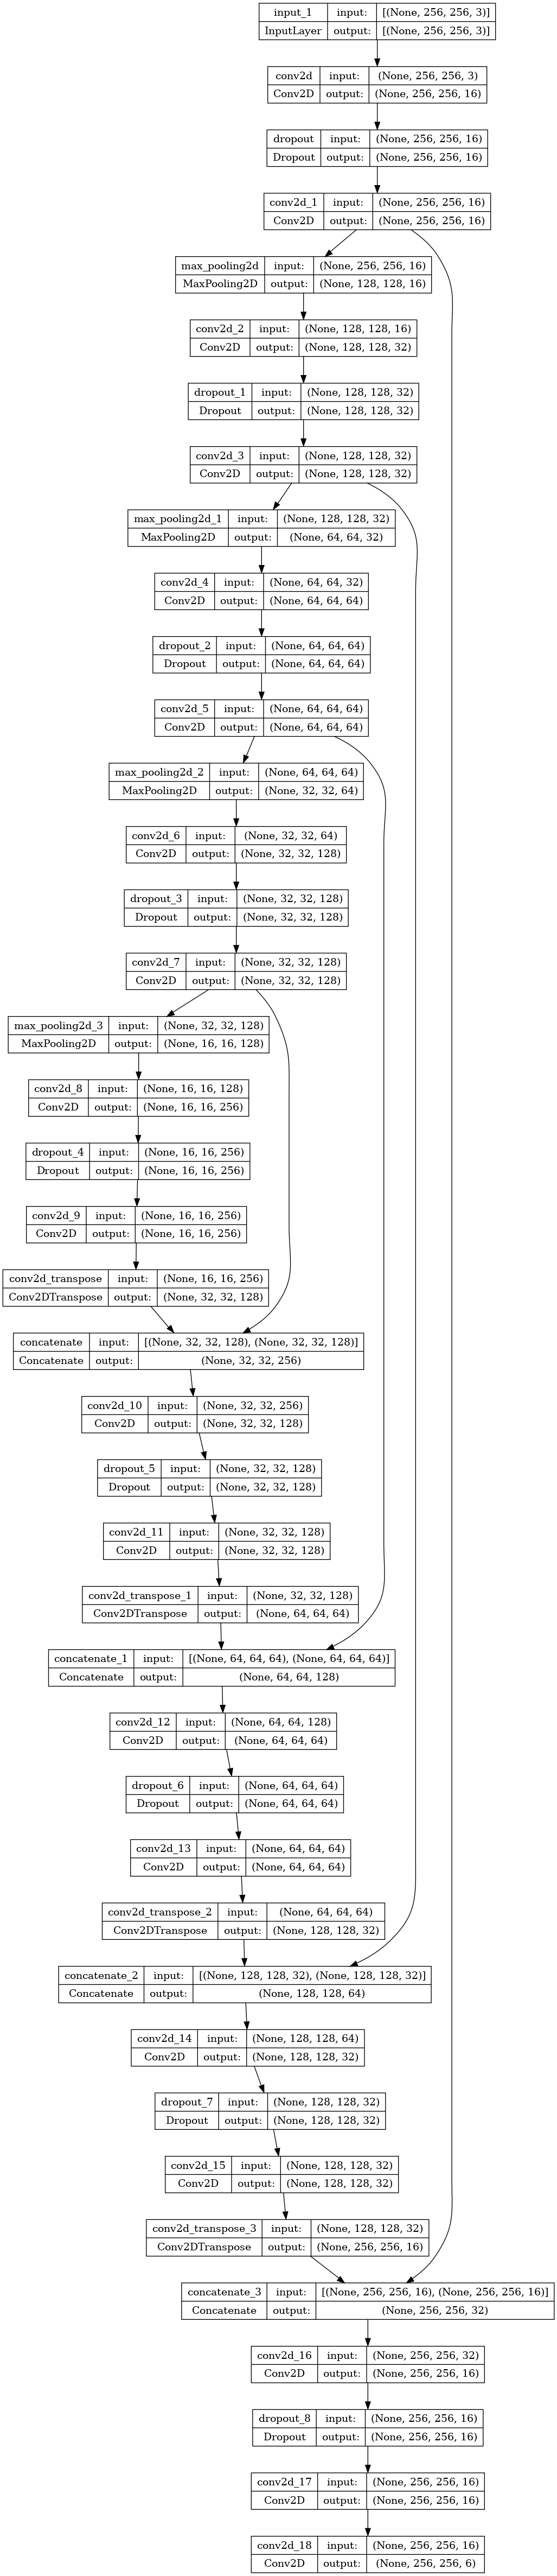

In [34]:
plot_model(model, to_file='satellite_model_plot.png', show_shapes=True, show_layer_names=True)

In [35]:
import keras
from IPython.display import display, clear_output
%matplotlib inline

In [36]:
class PlotMetrics(keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.epochs = []
        self.losses = []
        self.val_losses = []
        self.accuracy = []
        self.val_accuracy = []
        self.jaccard_coef = []
        self.val_jaccard_coef = []

        self.fig, self.axes = plt.subplots(1, 3, figsize=(20, 4))
        plt.ion()

    def on_epoch_end(self, epoch, logs=None):
        self.epochs.append(epoch + 1)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.accuracy.append(logs.get('accuracy'))
        self.val_accuracy.append(logs.get('val_accuracy'))
        self.jaccard_coef.append(logs.get('jaccard_coef'))
        self.val_jaccard_coef.append(logs.get('val_jaccard_coef'))

        for ax in self.axes:
            ax.clear()

        self.axes[0].plot(self.epochs, self.losses, label='loss')
        self.axes[0].plot(self.epochs, self.val_losses, label='val_loss')
        self.axes[0].legend()
        self.axes[0].set_title('Loss')

        self.axes[1].plot(self.epochs, self.accuracy, label='accuracy')
        self.axes[1].plot(self.epochs, self.val_accuracy, label='val_accuracy')
        self.axes[1].legend()
        self.axes[1].set_title('Accuracy')

        self.axes[2].plot(self.epochs, self.jaccard_coef, label='jaccard_coef')
        self.axes[2].plot(self.epochs, self.val_jaccard_coef, label='val_jaccard_coef')
        self.axes[2].legend()
        self.axes[2].set_title('IoU')

        display(self.fig)
        clear_output(wait=True)

plot_loss = PlotMetrics()

In [37]:
import wandb
from wandb.keras import WandbCallback

In [38]:
wandb.init(project='satellite-segmentation-imagery', entity='ramanujachanduri')

wandb: Currently logged in as: ramanujachanduri. Use `wandb login --relogin` to force relogin
wandb: wandb version 0.16.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.15.9
wandb: Run data is saved locally in /kaggle/working/wandb/run-20231121_101128-8n7yokla
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run exalted-silence-4
wandb: ⭐️ View project at https://wandb.ai/ramanujachanduri/satellite-segmentation-imagery
wandb: 🚀 View run at https://wandb.ai/ramanujachanduri/satellite-segmentation-imagery/runs/8n7yokla


In [39]:
wandb.log({'accuracy': jaccard_coef, 'loss': total_loss})

In [40]:
wandb.config.dropout = 0.2

In [41]:
model_history = model.fit(x_train, y_train, batch_size=16,
                          verbose=1, epochs=100,
                          validation_data=(x_test, y_test),
                          # callbacks=[plot_loss],
                          callbacks = [WandbCallback()],
                          shuffle=False)

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/100


2023-11-21 10:12:35.270323: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


66/66 [==============================] - ETA: 0s - loss: 0.9958 - accuracy: 0.5034 - jaccard_coef: 0.2682

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20231121_101128-8n7yokla/files/model-best)... Done. 0.1s


66/66 [==============================] - 45s 351ms/step - loss: 0.9958 - accuracy: 0.5034 - jaccard_coef: 0.2682 - val_loss: 0.9620 - val_accuracy: 0.7214 - val_jaccard_coef: 0.4400
Epoch 2/100
66/66 [==============================] - ETA: 0s - loss: 0.9556 - accuracy: 0.7330 - jaccard_coef: 0.4847

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20231121_101128-8n7yokla/files/model-best)... Done. 0.1s


66/66 [==============================] - 18s 277ms/step - loss: 0.9556 - accuracy: 0.7330 - jaccard_coef: 0.4847 - val_loss: 0.9541 - val_accuracy: 0.7253 - val_jaccard_coef: 0.4995
Epoch 3/100
66/66 [==============================] - 13s 194ms/step - loss: 0.9468 - accuracy: 0.7597 - jaccard_coef: 0.5286 - val_loss: 0.9570 - val_accuracy: 0.7221 - val_jaccard_coef: 0.5079
Epoch 4/100
66/66 [==============================] - 13s 196ms/step - loss: 0.9412 - accuracy: 0.7785 - jaccard_coef: 0.5606 - val_loss: 0.9613 - val_accuracy: 0.7194 - val_jaccard_coef: 0.5126
Epoch 5/100
66/66 [==============================] - 13s 198ms/step - loss: 0.9372 - accuracy: 0.7892 - jaccard_coef: 0.5782 - val_loss: 0.9619 - val_accuracy: 0.7350 - val_jaccard_coef: 0.5506
Epoch 6/100
66/66 [==============================] - 13s 200ms/step - loss: 0.9350 - accuracy: 0.7962 - jaccard_coef: 0.5927 - val_loss: 0.9555 - val_accuracy: 0.7451 - val_jaccard_coef: 0.5547
Epoch 7/100
66/66 [=======================

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20231121_101128-8n7yokla/files/model-best)... Done. 0.1s


66/66 [==============================] - 19s 293ms/step - loss: 0.9301 - accuracy: 0.8118 - jaccard_coef: 0.6180 - val_loss: 0.9428 - val_accuracy: 0.7880 - val_jaccard_coef: 0.6072
Epoch 8/100
66/66 [==============================] - ETA: 0s - loss: 0.9268 - accuracy: 0.8215 - jaccard_coef: 0.6348

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20231121_101128-8n7yokla/files/model-best)... Done. 0.1s


66/66 [==============================] - 19s 293ms/step - loss: 0.9268 - accuracy: 0.8215 - jaccard_coef: 0.6348 - val_loss: 0.9341 - val_accuracy: 0.8076 - val_jaccard_coef: 0.6272
Epoch 9/100
66/66 [==============================] - ETA: 0s - loss: 0.9234 - accuracy: 0.8317 - jaccard_coef: 0.6507

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20231121_101128-8n7yokla/files/model-best)... Done. 0.1s


66/66 [==============================] - 19s 287ms/step - loss: 0.9234 - accuracy: 0.8317 - jaccard_coef: 0.6507 - val_loss: 0.9233 - val_accuracy: 0.8319 - val_jaccard_coef: 0.6636
Epoch 10/100
66/66 [==============================] - ETA: 0s - loss: 0.9203 - accuracy: 0.8396 - jaccard_coef: 0.6666

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20231121_101128-8n7yokla/files/model-best)... Done. 0.1s


66/66 [==============================] - 19s 294ms/step - loss: 0.9203 - accuracy: 0.8396 - jaccard_coef: 0.6666 - val_loss: 0.9218 - val_accuracy: 0.8334 - val_jaccard_coef: 0.6734
Epoch 11/100
66/66 [==============================] - ETA: 0s - loss: 0.9191 - accuracy: 0.8426 - jaccard_coef: 0.6718

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20231121_101128-8n7yokla/files/model-best)... Done. 0.1s


66/66 [==============================] - 19s 292ms/step - loss: 0.9191 - accuracy: 0.8426 - jaccard_coef: 0.6718 - val_loss: 0.9194 - val_accuracy: 0.8397 - val_jaccard_coef: 0.6840
Epoch 12/100
66/66 [==============================] - 13s 203ms/step - loss: 0.9175 - accuracy: 0.8462 - jaccard_coef: 0.6786 - val_loss: 0.9203 - val_accuracy: 0.8356 - val_jaccard_coef: 0.6798
Epoch 13/100
66/66 [==============================] - 13s 204ms/step - loss: 0.9166 - accuracy: 0.8486 - jaccard_coef: 0.6830 - val_loss: 0.9197 - val_accuracy: 0.8376 - val_jaccard_coef: 0.6797
Epoch 14/100
66/66 [==============================] - ETA: 0s - loss: 0.9159 - accuracy: 0.8503 - jaccard_coef: 0.6856

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20231121_101128-8n7yokla/files/model-best)... Done. 0.1s


66/66 [==============================] - 19s 292ms/step - loss: 0.9159 - accuracy: 0.8503 - jaccard_coef: 0.6856 - val_loss: 0.9187 - val_accuracy: 0.8382 - val_jaccard_coef: 0.6847
Epoch 15/100
66/66 [==============================] - 13s 202ms/step - loss: 0.9155 - accuracy: 0.8511 - jaccard_coef: 0.6872 - val_loss: 0.9191 - val_accuracy: 0.8365 - val_jaccard_coef: 0.6851
Epoch 16/100
66/66 [==============================] - 13s 203ms/step - loss: 0.9226 - accuracy: 0.8302 - jaccard_coef: 0.6506 - val_loss: 0.9315 - val_accuracy: 0.7947 - val_jaccard_coef: 0.6201
Epoch 17/100
66/66 [==============================] - 13s 204ms/step - loss: 0.9184 - accuracy: 0.8416 - jaccard_coef: 0.6706 - val_loss: 0.9242 - val_accuracy: 0.8199 - val_jaccard_coef: 0.6588
Epoch 18/100
66/66 [==============================] - 13s 203ms/step - loss: 0.9159 - accuracy: 0.8506 - jaccard_coef: 0.6865 - val_loss: 0.9250 - val_accuracy: 0.8191 - val_jaccard_coef: 0.6620
Epoch 19/100
66/66 [==================

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20231121_101128-8n7yokla/files/model-best)... Done. 0.1s


66/66 [==============================] - 19s 285ms/step - loss: 0.9111 - accuracy: 0.8619 - jaccard_coef: 0.7072 - val_loss: 0.9186 - val_accuracy: 0.8378 - val_jaccard_coef: 0.6881
Epoch 25/100
66/66 [==============================] - 13s 202ms/step - loss: 0.9106 - accuracy: 0.8628 - jaccard_coef: 0.7087 - val_loss: 0.9210 - val_accuracy: 0.8331 - val_jaccard_coef: 0.6865
Epoch 26/100
66/66 [==============================] - 13s 204ms/step - loss: 0.9098 - accuracy: 0.8649 - jaccard_coef: 0.7129 - val_loss: 0.9194 - val_accuracy: 0.8364 - val_jaccard_coef: 0.6899
Epoch 27/100
66/66 [==============================] - 13s 204ms/step - loss: 0.9091 - accuracy: 0.8673 - jaccard_coef: 0.7171 - val_loss: 0.9207 - val_accuracy: 0.8354 - val_jaccard_coef: 0.6893
Epoch 28/100
66/66 [==============================] - ETA: 0s - loss: 0.9094 - accuracy: 0.8664 - jaccard_coef: 0.7146

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20231121_101128-8n7yokla/files/model-best)... Done. 0.1s


66/66 [==============================] - 19s 293ms/step - loss: 0.9094 - accuracy: 0.8664 - jaccard_coef: 0.7146 - val_loss: 0.9182 - val_accuracy: 0.8411 - val_jaccard_coef: 0.6944
Epoch 29/100
66/66 [==============================] - 13s 202ms/step - loss: 0.9092 - accuracy: 0.8666 - jaccard_coef: 0.7157 - val_loss: 0.9224 - val_accuracy: 0.8260 - val_jaccard_coef: 0.6705
Epoch 30/100
66/66 [==============================] - 13s 204ms/step - loss: 0.9128 - accuracy: 0.8562 - jaccard_coef: 0.6963 - val_loss: 0.9336 - val_accuracy: 0.7900 - val_jaccard_coef: 0.6123
Epoch 31/100
66/66 [==============================] - 13s 204ms/step - loss: 0.9106 - accuracy: 0.8627 - jaccard_coef: 0.7086 - val_loss: 0.9228 - val_accuracy: 0.8200 - val_jaccard_coef: 0.6669
Epoch 32/100
66/66 [==============================] - 13s 204ms/step - loss: 0.9085 - accuracy: 0.8689 - jaccard_coef: 0.7198 - val_loss: 0.9185 - val_accuracy: 0.8380 - val_jaccard_coef: 0.6868
Epoch 33/100
66/66 [==================

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20231121_101128-8n7yokla/files/model-best)... Done. 0.1s


66/66 [==============================] - 19s 291ms/step - loss: 0.9077 - accuracy: 0.8714 - jaccard_coef: 0.7234 - val_loss: 0.9175 - val_accuracy: 0.8418 - val_jaccard_coef: 0.6967
Epoch 34/100
66/66 [==============================] - 13s 202ms/step - loss: 0.9075 - accuracy: 0.8711 - jaccard_coef: 0.7240 - val_loss: 0.9196 - val_accuracy: 0.8333 - val_jaccard_coef: 0.6854
Epoch 35/100
66/66 [==============================] - ETA: 0s - loss: 0.9065 - accuracy: 0.8743 - jaccard_coef: 0.7283

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20231121_101128-8n7yokla/files/model-best)... Done. 0.1s


66/66 [==============================] - 19s 287ms/step - loss: 0.9065 - accuracy: 0.8743 - jaccard_coef: 0.7283 - val_loss: 0.9166 - val_accuracy: 0.8461 - val_jaccard_coef: 0.7068
Epoch 36/100
66/66 [==============================] - 13s 203ms/step - loss: 0.9057 - accuracy: 0.8763 - jaccard_coef: 0.7322 - val_loss: 0.9185 - val_accuracy: 0.8391 - val_jaccard_coef: 0.6979
Epoch 37/100
66/66 [==============================] - ETA: 0s - loss: 0.9054 - accuracy: 0.8769 - jaccard_coef: 0.7326

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20231121_101128-8n7yokla/files/model-best)... Done. 0.1s


66/66 [==============================] - 19s 294ms/step - loss: 0.9054 - accuracy: 0.8769 - jaccard_coef: 0.7326 - val_loss: 0.9163 - val_accuracy: 0.8450 - val_jaccard_coef: 0.7043
Epoch 38/100
66/66 [==============================] - 13s 202ms/step - loss: 0.9049 - accuracy: 0.8781 - jaccard_coef: 0.7351 - val_loss: 0.9195 - val_accuracy: 0.8394 - val_jaccard_coef: 0.6972
Epoch 39/100
66/66 [==============================] - 13s 204ms/step - loss: 0.9069 - accuracy: 0.8722 - jaccard_coef: 0.7247 - val_loss: 0.9168 - val_accuracy: 0.8433 - val_jaccard_coef: 0.7001
Epoch 40/100
66/66 [==============================] - ETA: 0s - loss: 0.9045 - accuracy: 0.8787 - jaccard_coef: 0.7361

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20231121_101128-8n7yokla/files/model-best)... Done. 0.1s


66/66 [==============================] - 19s 293ms/step - loss: 0.9045 - accuracy: 0.8787 - jaccard_coef: 0.7361 - val_loss: 0.9140 - val_accuracy: 0.8514 - val_jaccard_coef: 0.7136
Epoch 41/100
66/66 [==============================] - 13s 203ms/step - loss: 0.9033 - accuracy: 0.8811 - jaccard_coef: 0.7412 - val_loss: 0.9154 - val_accuracy: 0.8474 - val_jaccard_coef: 0.7073
Epoch 42/100
66/66 [==============================] - 13s 203ms/step - loss: 0.9033 - accuracy: 0.8801 - jaccard_coef: 0.7407 - val_loss: 0.9142 - val_accuracy: 0.8510 - val_jaccard_coef: 0.7125
Epoch 43/100
66/66 [==============================] - 13s 204ms/step - loss: 0.9024 - accuracy: 0.8806 - jaccard_coef: 0.7448 - val_loss: 0.9177 - val_accuracy: 0.8469 - val_jaccard_coef: 0.7080
Epoch 44/100
66/66 [==============================] - 13s 203ms/step - loss: 0.9043 - accuracy: 0.8745 - jaccard_coef: 0.7358 - val_loss: 0.9153 - val_accuracy: 0.8459 - val_jaccard_coef: 0.6879
Epoch 45/100
66/66 [==================

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20231121_101128-8n7yokla/files/model-best)... Done. 0.1s


66/66 [==============================] - 19s 285ms/step - loss: 0.9051 - accuracy: 0.8739 - jaccard_coef: 0.7333 - val_loss: 0.9123 - val_accuracy: 0.8545 - val_jaccard_coef: 0.7143
Epoch 46/100
66/66 [==============================] - ETA: 0s - loss: 0.9028 - accuracy: 0.8781 - jaccard_coef: 0.7437

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20231121_101128-8n7yokla/files/model-best)... Done. 0.1s


66/66 [==============================] - 19s 291ms/step - loss: 0.9028 - accuracy: 0.8781 - jaccard_coef: 0.7437 - val_loss: 0.9120 - val_accuracy: 0.8494 - val_jaccard_coef: 0.7083
Epoch 47/100
66/66 [==============================] - 13s 204ms/step - loss: 0.9017 - accuracy: 0.8795 - jaccard_coef: 0.7472 - val_loss: 0.9136 - val_accuracy: 0.8462 - val_jaccard_coef: 0.7060
Epoch 48/100
66/66 [==============================] - 13s 205ms/step - loss: 0.9016 - accuracy: 0.8795 - jaccard_coef: 0.7491 - val_loss: 0.9152 - val_accuracy: 0.8441 - val_jaccard_coef: 0.7032
Epoch 49/100
66/66 [==============================] - ETA: 0s - loss: 0.9008 - accuracy: 0.8818 - jaccard_coef: 0.7520

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20231121_101128-8n7yokla/files/model-best)... Done. 0.1s


66/66 [==============================] - 19s 291ms/step - loss: 0.9008 - accuracy: 0.8818 - jaccard_coef: 0.7520 - val_loss: 0.9105 - val_accuracy: 0.8585 - val_jaccard_coef: 0.7230
Epoch 50/100
66/66 [==============================] - 13s 202ms/step - loss: 0.9012 - accuracy: 0.8800 - jaccard_coef: 0.7498 - val_loss: 0.9108 - val_accuracy: 0.8539 - val_jaccard_coef: 0.7162
Epoch 51/100
66/66 [==============================] - 13s 202ms/step - loss: 0.9014 - accuracy: 0.8795 - jaccard_coef: 0.7486 - val_loss: 0.9163 - val_accuracy: 0.8416 - val_jaccard_coef: 0.7053
Epoch 52/100
66/66 [==============================] - 13s 204ms/step - loss: 0.9016 - accuracy: 0.8795 - jaccard_coef: 0.7495 - val_loss: 0.9159 - val_accuracy: 0.8377 - val_jaccard_coef: 0.6971
Epoch 53/100
66/66 [==============================] - ETA: 0s - loss: 0.9009 - accuracy: 0.8801 - jaccard_coef: 0.7501

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20231121_101128-8n7yokla/files/model-best)... Done. 0.1s


66/66 [==============================] - 19s 292ms/step - loss: 0.9009 - accuracy: 0.8801 - jaccard_coef: 0.7501 - val_loss: 0.9066 - val_accuracy: 0.8635 - val_jaccard_coef: 0.7338
Epoch 54/100
66/66 [==============================] - 13s 202ms/step - loss: 0.9014 - accuracy: 0.8774 - jaccard_coef: 0.7458 - val_loss: 0.9117 - val_accuracy: 0.8547 - val_jaccard_coef: 0.7184
Epoch 55/100
66/66 [==============================] - 13s 204ms/step - loss: 0.9025 - accuracy: 0.8750 - jaccard_coef: 0.7412 - val_loss: 0.9147 - val_accuracy: 0.8474 - val_jaccard_coef: 0.6945
Epoch 56/100
66/66 [==============================] - 13s 203ms/step - loss: 0.9006 - accuracy: 0.8783 - jaccard_coef: 0.7465 - val_loss: 0.9116 - val_accuracy: 0.8566 - val_jaccard_coef: 0.7153
Epoch 57/100
66/66 [==============================] - 13s 202ms/step - loss: 0.9026 - accuracy: 0.8746 - jaccard_coef: 0.7396 - val_loss: 0.9143 - val_accuracy: 0.8498 - val_jaccard_coef: 0.7159
Epoch 58/100
66/66 [==================

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20231121_101128-8n7yokla/files/model-best)... Done. 0.1s


66/66 [==============================] - 19s 284ms/step - loss: 0.8964 - accuracy: 0.8846 - jaccard_coef: 0.7584 - val_loss: 0.9045 - val_accuracy: 0.8689 - val_jaccard_coef: 0.7356
Epoch 68/100
66/66 [==============================] - 13s 201ms/step - loss: 0.8953 - accuracy: 0.8861 - jaccard_coef: 0.7607 - val_loss: 0.9056 - val_accuracy: 0.8715 - val_jaccard_coef: 0.7451
Epoch 69/100
66/66 [==============================] - 13s 204ms/step - loss: 0.8964 - accuracy: 0.8831 - jaccard_coef: 0.7546 - val_loss: 0.9065 - val_accuracy: 0.8659 - val_jaccard_coef: 0.7359
Epoch 70/100
66/66 [==============================] - ETA: 0s - loss: 0.8929 - accuracy: 0.8897 - jaccard_coef: 0.7680

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20231121_101128-8n7yokla/files/model-best)... Done. 0.1s


66/66 [==============================] - 19s 292ms/step - loss: 0.8929 - accuracy: 0.8897 - jaccard_coef: 0.7680 - val_loss: 0.9034 - val_accuracy: 0.8762 - val_jaccard_coef: 0.7549
Epoch 71/100
66/66 [==============================] - 13s 202ms/step - loss: 0.8909 - accuracy: 0.8928 - jaccard_coef: 0.7731 - val_loss: 0.9075 - val_accuracy: 0.8682 - val_jaccard_coef: 0.7427
Epoch 72/100
66/66 [==============================] - 13s 203ms/step - loss: 0.8904 - accuracy: 0.8941 - jaccard_coef: 0.7755 - val_loss: 0.9036 - val_accuracy: 0.8756 - val_jaccard_coef: 0.7551
Epoch 73/100
66/66 [==============================] - 13s 203ms/step - loss: 0.8903 - accuracy: 0.8943 - jaccard_coef: 0.7762 - val_loss: 0.9051 - val_accuracy: 0.8708 - val_jaccard_coef: 0.7491
Epoch 74/100
66/66 [==============================] - 13s 202ms/step - loss: 0.8913 - accuracy: 0.8921 - jaccard_coef: 0.7714 - val_loss: 0.9115 - val_accuracy: 0.8533 - val_jaccard_coef: 0.7206
Epoch 75/100
66/66 [==================

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20231121_101128-8n7yokla/files/model-best)... Done. 0.1s


66/66 [==============================] - 19s 289ms/step - loss: 0.8880 - accuracy: 0.8975 - jaccard_coef: 0.7813 - val_loss: 0.9028 - val_accuracy: 0.8794 - val_jaccard_coef: 0.7606
Epoch 88/100
66/66 [==============================] - ETA: 0s - loss: 0.8906 - accuracy: 0.8911 - jaccard_coef: 0.7699

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20231121_101128-8n7yokla/files/model-best)... Done. 0.1s


66/66 [==============================] - 19s 282ms/step - loss: 0.8906 - accuracy: 0.8911 - jaccard_coef: 0.7699 - val_loss: 0.9027 - val_accuracy: 0.8787 - val_jaccard_coef: 0.7588
Epoch 89/100
66/66 [==============================] - ETA: 0s - loss: 0.8884 - accuracy: 0.8966 - jaccard_coef: 0.7807

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20231121_101128-8n7yokla/files/model-best)... Done. 0.1s


66/66 [==============================] - 19s 293ms/step - loss: 0.8884 - accuracy: 0.8966 - jaccard_coef: 0.7807 - val_loss: 0.9016 - val_accuracy: 0.8825 - val_jaccard_coef: 0.7636
Epoch 90/100
66/66 [==============================] - 13s 203ms/step - loss: 0.8891 - accuracy: 0.8962 - jaccard_coef: 0.7789 - val_loss: 0.9038 - val_accuracy: 0.8782 - val_jaccard_coef: 0.7593
Epoch 91/100
66/66 [==============================] - 13s 204ms/step - loss: 0.8876 - accuracy: 0.8985 - jaccard_coef: 0.7839 - val_loss: 0.9023 - val_accuracy: 0.8808 - val_jaccard_coef: 0.7604
Epoch 92/100
66/66 [==============================] - 13s 203ms/step - loss: 0.8941 - accuracy: 0.8864 - jaccard_coef: 0.7602 - val_loss: 0.9080 - val_accuracy: 0.8651 - val_jaccard_coef: 0.7245
Epoch 93/100
66/66 [==============================] - 13s 201ms/step - loss: 0.8914 - accuracy: 0.8924 - jaccard_coef: 0.7711 - val_loss: 0.9108 - val_accuracy: 0.8629 - val_jaccard_coef: 0.7319
Epoch 94/100
66/66 [==================

In [42]:
model_history.params

{'verbose': 1, 'epochs': 100, 'steps': 66}

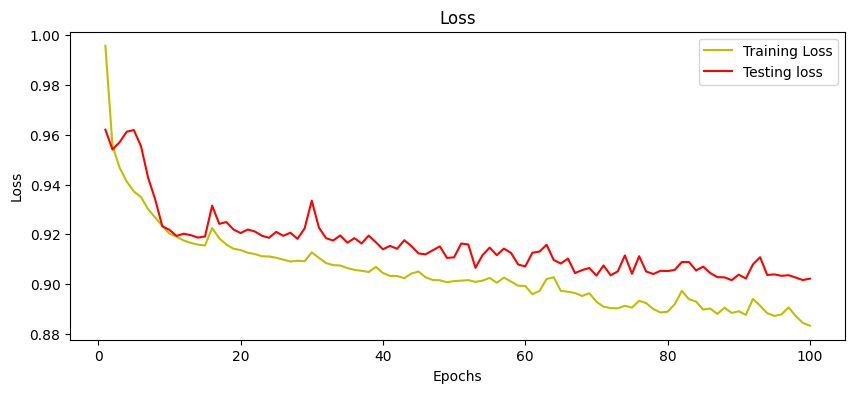

In [43]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
epochs = range(1,len(loss) + 1)

plt.figure(figsize=(10,4))

plt.plot(epochs, loss, 'y', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Testing loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

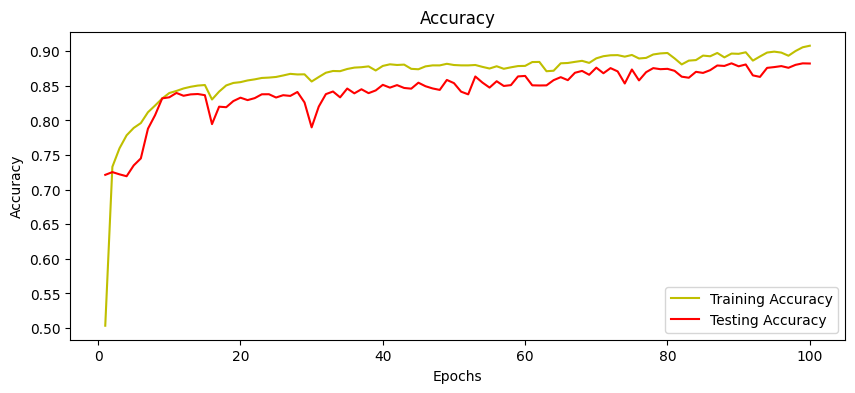

In [44]:
accuracy = model_history.history['accuracy']
val_accuracy = model_history.history['val_accuracy']
epochs = range(1,len(accuracy) + 1)

plt.figure(figsize=(10,4))

plt.plot(epochs, accuracy, 'y', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Testing Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

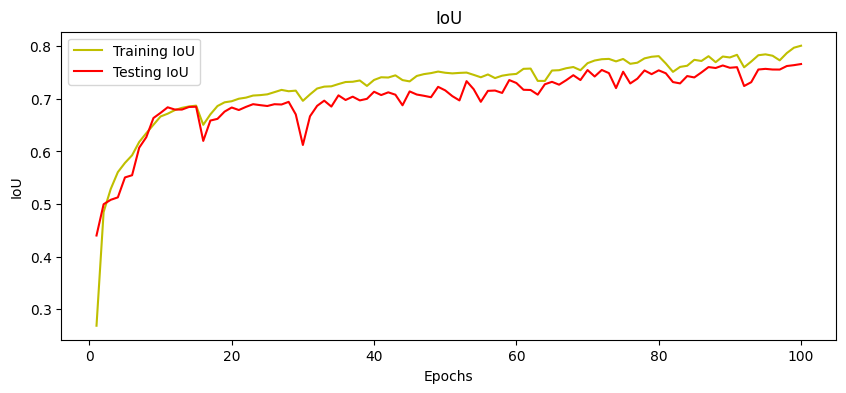

In [45]:
jaccard_coef = model_history.history['jaccard_coef']
val_jaccard_coef = model_history.history['val_jaccard_coef']
epochs = range(1,len(jaccard_coef) + 1)

plt.figure(figsize=(10,4))

plt.plot(epochs, jaccard_coef, 'y', label='Training IoU')
plt.plot(epochs, val_jaccard_coef, 'r', label='Testing IoU')
plt.title('IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()

## Model Prediction

In [46]:
# Prediction
y_pred = model.predict(x_test)
y_pred_argmax = np.argmax(y_pred, axis=3)

y_test_argmax = np.argmax(y_pred, axis=3)

9/9 [==============================] - 3s 64ms/step


## Comparing prediction results

220
1/1 [==============================] - 1s 595ms/step


Text(0.5, 1.0, 'Predicted Image')

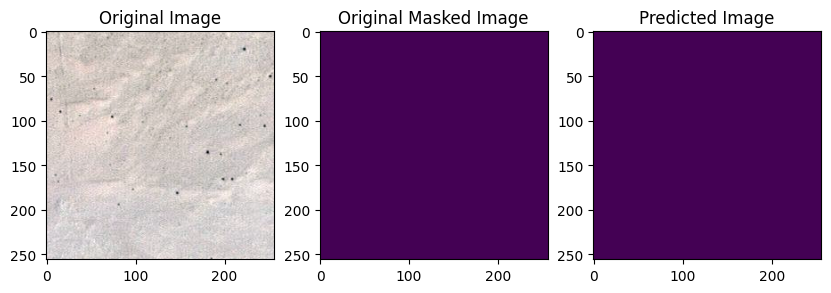

In [47]:
test_image_number = random.randint(0, len(x_test))
print(test_image_number)
test_image = x_test[test_image_number]
ground_truth_image = y_test_argmax[test_image_number]

test_image_input = np.expand_dims(test_image, 0)

# prediction = saved_model.predict(test_image_input)
prediction = model.predict(test_image_input)
prediction_image = np.argmax(prediction, axis = 3)
predicted_image = prediction_image[0,:,:]

plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
plt.imshow(test_image)
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(ground_truth_image)
plt.title('Original Masked Image')
plt.subplot(1,3,3)
plt.imshow(predicted_image)
plt.title('Predicted Image')

In [48]:
model.save('satellite_segmentation_full.h5')

## Model saving and reloading(with custom loss)

In [49]:
# model.get_config()
model.save('satellite_segmentation.h5')

In [50]:
from keras.models import load_model

In [51]:
saved_model = load_model('/kaggle/working/satellite_segmentation.h5', custom_objects=({'dice_loss_plus_1focal_loss': total_loss, 'jaccard_coef': jaccard_coef}))

## Performing custom image prediction from google maps

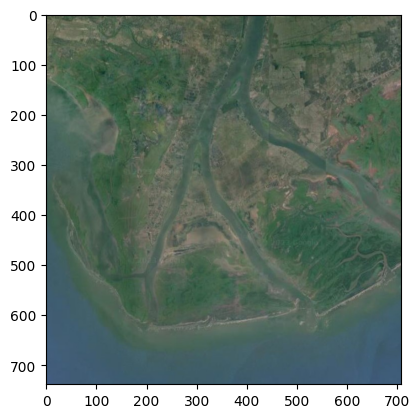

In [52]:
plt.imshow(Image.open('/kaggle/input/satellite-imagery-test-data/image1.jpg'))

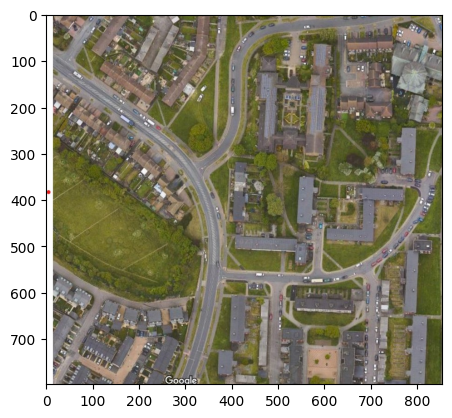

In [53]:
plt.imshow(Image.open('/kaggle/input/satellite-imagery-test-data/image2.jpg'))

In [54]:
image1 = Image.open('/kaggle/input/satellite-imagery-test-data/image1.jpg')
image1 = image1.resize((256, 256))
image1 = np.array(image1)
image1 = np.expand_dims(image1, 0)

In [55]:
image2 = Image.open('/kaggle/input/satellite-imagery-test-data/image2.jpg')
image2 = image2.resize((256, 256))
image2 = np.array(image2)
image2 = np.expand_dims(image2, 0)

In [56]:
prediction = saved_model.predict(image2)

1/1 [==============================] - 0s 260ms/step


In [57]:
predicted_image = np.argmax(prediction, axis = 3)[0,:,:]

Text(0.5, 1.0, 'Predicted Image')

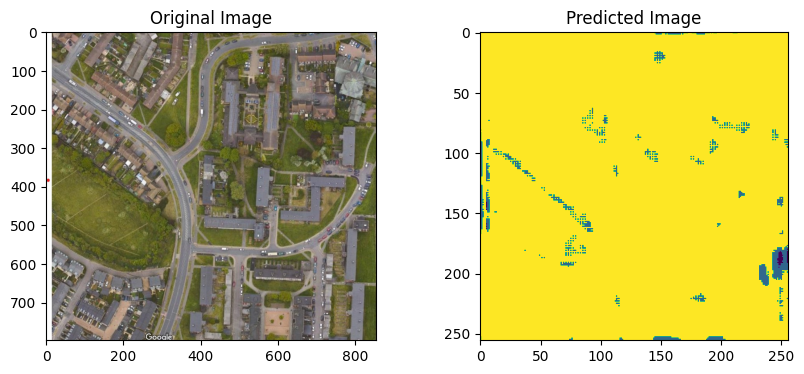

In [58]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(Image.open('/kaggle/input/satellite-imagery-test-data/image2.jpg'))
plt.title('Original Image')
plt.subplot(1,2,2)
plt.imshow(predicted_image)
plt.title('Predicted Image')

In [59]:
import keract as ke

In [60]:
import os

folder_path = '/kaggle/working/activations'
os.makedirs(folder_path, exist_ok=True)

In [61]:
activations = ke.get_activations(saved_model, image1, nodes_to_evaluate=None, output_format='simple', auto_compile=True)

In [62]:
ke.display_activations(activations, cmap='viridis', save=True, directory='/kaggle/working/activations')

input_1 (1, 256, 256, 3) 
conv2d (1, 256, 256, 16) 
dropout (1, 256, 256, 16) 
conv2d_1 (1, 256, 256, 16) 
max_pooling2d (1, 128, 128, 16) 
conv2d_2 (1, 128, 128, 32) 
dropout_1 (1, 128, 128, 32) 
conv2d_3 (1, 128, 128, 32) 
max_pooling2d_1 (1, 64, 64, 32) 
conv2d_4 (1, 64, 64, 64) 
dropout_2 (1, 64, 64, 64) 
conv2d_5 (1, 64, 64, 64) 
max_pooling2d_2 (1, 32, 32, 64) 
conv2d_6 (1, 32, 32, 128) 
dropout_3 (1, 32, 32, 128) 
conv2d_7 (1, 32, 32, 128) 
max_pooling2d_3 (1, 16, 16, 128) 
conv2d_8 (1, 16, 16, 256) 
dropout_4 (1, 16, 16, 256) 
conv2d_9 (1, 16, 16, 256) 
conv2d_transpose (1, 32, 32, 128) 
concatenate (1, 32, 32, 256) 
conv2d_10 (1, 32, 32, 128) 
dropout_5 (1, 32, 32, 128) 
conv2d_11 (1, 32, 32, 128) 
conv2d_transpose_1 (1, 64, 64, 64) 
concatenate_1 (1, 64, 64, 128) 
conv2d_12 (1, 64, 64, 64) 
dropout_6 (1, 64, 64, 64) 
conv2d_13 (1, 64, 64, 64) 
conv2d_transpose_2 (1, 128, 128, 32) 
concatenate_2 (1, 128, 128, 64) 
conv2d_14 (1, 128, 128, 32) 
dropout_7 (1, 128, 128, 32) 
conv2

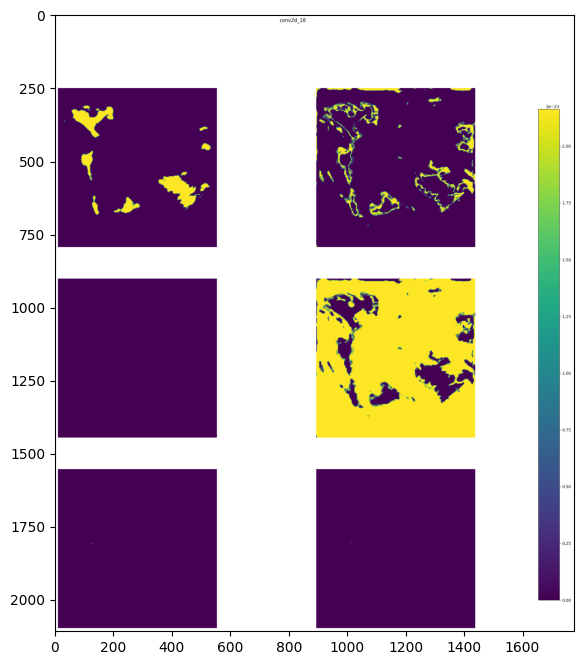

In [63]:
plt.figure(figsize=(8,8))
plt.imshow(Image.open('/kaggle/working/activations/40_conv2d_18.png'))

In [64]:
folder_path = '/kaggle/working/heatmaps'
os.makedirs(folder_path, exist_ok=True)

In [65]:
image1 = Image.open('/kaggle/input/satellite-imagery-test-data/image1.jpg')
image1 = image1.resize((256, 256))
image_as_array = np.array(image1)
image_as_array = image_as_array.astype(np.float32)
ke.display_heatmaps(activations, image_as_array, save=True, directory='/kaggle/working/heatmaps')

input_1 (1, 256, 256, 3) 
conv2d (1, 256, 256, 16) 
dropout (1, 256, 256, 16) 
conv2d_1 (1, 256, 256, 16) 
max_pooling2d (1, 128, 128, 16) 
conv2d_2 (1, 128, 128, 32) 
dropout_1 (1, 128, 128, 32) 
conv2d_3 (1, 128, 128, 32) 
max_pooling2d_1 (1, 64, 64, 32) 
conv2d_4 (1, 64, 64, 64) 
dropout_2 (1, 64, 64, 64) 
conv2d_5 (1, 64, 64, 64) 
max_pooling2d_2 (1, 32, 32, 64) 
conv2d_6 (1, 32, 32, 128) 
dropout_3 (1, 32, 32, 128) 
conv2d_7 (1, 32, 32, 128) 
max_pooling2d_3 (1, 16, 16, 128) 
conv2d_8 (1, 16, 16, 256) 
dropout_4 (1, 16, 16, 256) 
conv2d_9 (1, 16, 16, 256) 
conv2d_transpose (1, 32, 32, 128) 
concatenate (1, 32, 32, 256) 
conv2d_10 (1, 32, 32, 128) 
dropout_5 (1, 32, 32, 128) 
conv2d_11 (1, 32, 32, 128) 
conv2d_transpose_1 (1, 64, 64, 64) 
concatenate_1 (1, 64, 64, 128) 
conv2d_12 (1, 64, 64, 64) 
dropout_6 (1, 64, 64, 64) 
conv2d_13 (1, 64, 64, 64) 
conv2d_transpose_2 (1, 128, 128, 32) 
concatenate_2 (1, 128, 128, 64) 
conv2d_14 (1, 128, 128, 32) 
dropout_7 (1, 128, 128, 32) 
conv2